Based on https://lajavaness.medium.com/1-token-classification-vs-span-categorization-52a685e4674a

In [1]:
import os 
os.chdir('/Users/daniel/Projects/Smaragd/sk-llm-01')

from datasets import Dataset
from transformers import AutoTokenizer, DataCollatorWithPadding, TrainingArguments, Trainer, BertConfig, get_scheduler

import numpy as np
import pandas as pd
from sklearn.metrics import multilabel_confusion_matrix

import fact_extraction_model.model.bert_multilabel_classification as model_multilabel
from torch.utils.data import DataLoader
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
import matplotlib.pyplot as plt

BASE_MODEL = "./serialized_models/medbert_512/"

MAX_LENGTH = 256

BATCH_SIZE = 24
LEARNING_RATE = 5e-5
WEIGHT_DECAY = 1e-2
NUM_EPOCHS = 100
OUTPUT_DIR = "./serialized_models/medbert_pretrained_multilabel/"

In [2]:
# Use method from shared-python
tag2id = {'PER': 1, 'ORG': 2, 'LOC': 3, 'MISC': 4, 'NCHUNK': 5, 'TIME': 6, 'PLACE': 7}
id2tag = {v:k for k, v in tag2id.items()}
id2tag

{1: 'PER', 2: 'ORG', 3: 'LOC', 4: 'MISC', 5: 'NCHUNK', 6: 'TIME', 7: 'PLACE'}

In [3]:
label2id = {
    'O': 0, 
    **{f'B-{k}': 2*v - 1 for k, v in tag2id.items()},
    **{f'I-{k}': 2*v for k, v in tag2id.items()}
}

id2label = {v:k for k, v in label2id.items()}
NUM_LABELS = len(id2label)
id2label


{0: 'O',
 1: 'B-PER',
 3: 'B-ORG',
 5: 'B-LOC',
 7: 'B-MISC',
 9: 'B-NCHUNK',
 11: 'B-TIME',
 13: 'B-PLACE',
 2: 'I-PER',
 4: 'I-ORG',
 6: 'I-LOC',
 8: 'I-MISC',
 10: 'I-NCHUNK',
 12: 'I-TIME',
 14: 'I-PLACE'}

In [4]:
train_ds = Dataset.from_json("./data/multilabel.train.jsonlines")
val_ds = Dataset.from_json("./data/multilabel.validation.jsonlines")
test_ds = Dataset.from_json("./data/multilabel.test.jsonlines")




Found cached dataset json (/Users/daniel/.cache/huggingface/datasets/json/default-068eea7cbca3671a/0.0.0)
Found cached dataset json (/Users/daniel/.cache/huggingface/datasets/json/default-5134848318b7c314/0.0.0)
Found cached dataset json (/Users/daniel/.cache/huggingface/datasets/json/default-a7132faaa4d75491/0.0.0)


In [5]:
#loader_cas = CASLoader(ANNOTATED_REPORTS_PATH)
#train_dict = loader_cas.load_CAS_convert_to_offset_dict()
#train_ds = Dataset.from_pandas(pd.DataFrame(data=train_dict))
#train_ds

In [6]:
def print_examples(): 
    for i in range(3):
        example = train_ds[i]
        print(f"\n{example['text']}")
        for tag_item in example["tags"]:
            print(tag_item["tag"].ljust(10), "-", example["text"][tag_item["start"]: tag_item["end"]])

print_examples()



Selon l'ethnologue Maurice Duval, « dire que ce mouvement de la gauche radicale est « une secte », ce n'est pas argumenter légitimement contre ses idées, mais c'est suggérer qu'il est malfaisant, malsain et que sa disparition serait souhaitable ».
PER        - Maurice Duval
NCHUNK     - l'ethnologue Maurice Duval
NCHUNK     - ses idées
NCHUNK     - sa disparition
NCHUNK     - ce mouvement de la gauche radicale

Adolescent, il joue de la basse dans un groupe de surf music, commence à composer et s'intéresse aux œuvres de musique contemporaine de compositeurs comme Charles Ives, Karlheinz Stockhausen, Mauricio Kagel, ou encore John Cage.
PER        - Charles Ives
PER        - Karlheinz Stockhausen
PER        - Mauricio Kagel
PER        - John Cage
NCHUNK     - un groupe de surf music
NCHUNK     - œuvres de musique contemporaine de compositeurs comme Charles Ives, Karlheinz Stockhausen, Mauricio Kagel, ou encore John Cage

Metacritic ", qui détermine une moyenne pondérée entre 0 et 100 b

In [7]:
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)

In [8]:
def get_token_role_in_span(token_start: int, token_end: int, span_start: int, span_end: int):
    """
    Check if the token is inside a span.
    Args:
      - token_start, token_end: Start and end offset of the token
      - span_start, span_end: Start and end of the span
    Returns:
      - "B" if beginning
      - "I" if inner
      - "O" if outer
      - "N" if not valid token (like <SEP>, <CLS>, <UNK>)
    """
    if token_end <= token_start:
        return "N"
    if token_start < span_start or token_end > span_end:
        return "O"
    if token_start > span_start:
        return "I"
    else:
        return "B"

def tokenize_and_adjust_labels(sample):
    """
    Args:
        - sample (dict): {"id": "...", "text": "...", "tags": [{"start": ..., "end": ..., "tag": ...}, ...]
    Returns:
        - The tokenized version of `sample` and the labels of each token.
    """
    # Tokenize the text, keep the start and end positions of tokens with `return_offsets_mapping` option
    # Use max_length and truncation to ajust the text length
    tokenized = tokenizer(sample["text"], 
                          return_offsets_mapping=True, 
                          padding="max_length", 
                          max_length=MAX_LENGTH,
                          truncation=True)
    
    # We are doing a multilabel classification task at each token, we create a list of size len(label2id)=13 
    # for the 13 labels
    labels = [[0 for _ in label2id.keys()] for _ in range(MAX_LENGTH)]
    
    # Scan all the tokens and spans, assign 1 to the corresponding label if the token lies at the beginning
    # or inside the spans
    for (token_start, token_end), token_labels in zip(tokenized["offset_mapping"], labels):
        for span in sample["tags"]:
            role = get_token_role_in_span(token_start, token_end, span["start"], span["end"])
            if role == "B":
                token_labels[label2id[f"B-{span['tag']}"]] = 1
            elif role == "I":
                token_labels[label2id[f"I-{span['tag']}"]] = 1
    
    return {**tokenized, "labels": labels}

In [9]:
tokenized_train_ds = train_ds.map(tokenize_and_adjust_labels, remove_columns=train_ds.column_names)
tokenized_val_ds = val_ds.map(tokenize_and_adjust_labels, remove_columns=val_ds.column_names)
tokenized_test_ds = test_ds.map(tokenize_and_adjust_labels, remove_columns=val_ds.column_names)



Map:   0%|          | 0/329 [00:00<?, ? examples/s]

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

Map:   0%|          | 0/43 [00:00<?, ? examples/s]

In [10]:
tokenized_train_ds[0]

{'input_ids': [2,
  6909,
  4668,
  80,
  11,
  13613,
  5047,
  26907,
  13041,
  5936,
  4684,
  10420,
  7174,
  6143,
  16,
  109,
  8633,
  7627,
  3528,
  71,
  3528,
  16741,
  9574,
  6219,
  5103,
  27365,
  75,
  5408,
  3528,
  7330,
  9816,
  3528,
  5148,
  3533,
  109,
  4990,
  3528,
  18432,
  4675,
  124,
  16,
  71,
  3528,
  82,
  11,
  5148,
  3533,
  17654,
  5626,
  7209,
  8591,
  3536,
  80,
  3589,
  11030,
  6110,
  6219,
  29521,
  4741,
  10810,
  3526,
  77,
  3540,
  3589,
  4672,
  16,
  5715,
  4677,
  71,
  11,
  5148,
  3533,
  5732,
  3541,
  3541,
  3589,
  4741,
  3536,
  7627,
  11,
  77,
  3522,
  5148,
  3533,
  5622,
  23460,
  4677,
  5008,
  16,
  5622,
  22885,
  4665,
  5124,
  7627,
  3528,
  25266,
  11617,
  8609,
  7315,
  10948,
  3527,
  4682,
  4809,
  15914,
  3527,
  29601,
  14464,
  124,
  18,
  3],
 'token_type_ids': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,


In [11]:

sample = tokenized_test_ds[0]

print("--------Token---------|--------Labels----------")
for token_id, token_labels in zip(sample["input_ids"], sample["labels"]):
    # Decode the token_id into text
    token_text = tokenizer.decode(token_id)
    
    # Retrieve all the indices corresponding to the "1" at each token, decode them to label name
    labels = [id2label[label_index] for label_index, value in enumerate(token_labels) if value==1]
    
    # Decode those indices into label name
    print(f" {token_text:20} | {labels}")
    
    # Finish when we meet the end of sentence.
    if token_text == "</s>": 
        break

--------Token---------|--------Labels----------
 [CLS]                | []
 Les                  | ['B-NCHUNK']
 part                 | ['I-NCHUNK']
 ##ies                | ['I-NCHUNK']
 pr                   | ['I-NCHUNK']
 ##é                  | ['I-NCHUNK']
 ##f                  | ['I-NCHUNK']
 ##é                  | ['I-NCHUNK']
 ##r                  | ['I-NCHUNK']
 ##é                  | ['I-NCHUNK']
 ##es                 | ['I-NCHUNK']
 son                  | []
 ##t                  | []
 les                  | []
 p                    | []
 ##in                 | []
 ##ces                | []
 et                   | []
 les                  | []
 pa                   | []
 ##tt                 | []
 ##es                 | []
 ,                    | []
 bie                  | []
 ##n                  | []
 qu                   | []
 ##e                  | []
 les                  | []
 œ                    | []
 ##uf                 | []
 ##s                  | []
 et            

In [12]:
#data_collator = DataCollatorWithPadding(tokenizer, padding=True)
data_collator = DataCollatorWithPadding(tokenizer, padding="longest", return_tensors="pt")

In [13]:
#Native pytorch code below
train_dl = DataLoader(
    tokenized_train_ds,
    shuffle=True,
    # sampler=SubsetRandomSampler(np.random.randint(0, encoded_gmb_dataset["train"].num_rows, 1000).tolist()),
    batch_size=BATCH_SIZE,
    collate_fn=data_collator,
)
valid_dl = DataLoader(
    tokenized_val_ds,
    shuffle=False,
    # sampler=SubsetRandomSampler(np.random.randint(0, encoded_gmb_dataset["validation"].num_rows, 200).tolist()),
    batch_size=BATCH_SIZE,
    collate_fn=data_collator,
)
test_dl = DataLoader(
    tokenized_test_ds,
    shuffle=False,
    #  sampler=SubsetRandomSampler(np.random.randint(0, encoded_gmb_dataset["test"].num_rows, 100).tolist()),
    batch_size=BATCH_SIZE,
    collate_fn=data_collator,
)


In [14]:
# Model instantiation
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
config = BertConfig.from_pretrained(BASE_MODEL)

model = model_multilabel.BertForMultiLabelClassification.from_pretrained(
    BASE_MODEL, num_labels=NUM_LABELS, label2id=label2id, id2label=id2label
)


# Resize embedding size if additional tokens are added (only for RE)
# model.bert.resize_token_embeddings(len(tokenizer.vocab))
model = model.to(device)

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

num_training_steps = NUM_EPOCHS * len(train_dl)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

Some weights of BertForMultiLabelClassification were not initialized from the model checkpoint at ./serialized_models/medbert_512/ and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
def divide(a: int, b: int):
    return a / b if b > 0 else 0

def compute_metrics(p):
    """
    Customize the `compute_metrics` of `transformers`
    Args:
        - p (tuple):      2 numpy arrays: predictions and true_labels
    Returns:
        - metrics (dict): f1 score on 
    """
    # (1)
    predictions, true_labels = p
    
    # (2)
    predicted_labels = np.where(predictions > 0, np.ones(predictions.shape), np.zeros(predictions.shape))
    metrics = {}
    
    # (3)
    cm = multilabel_confusion_matrix(true_labels.reshape(-1, NUM_LABELS), predicted_labels.reshape(-1, NUM_LABELS))
    
    # (4) 
    for label_idx, matrix in enumerate(cm):
        if label_idx == 0:
            continue # We don't care about the label "O"
        tp, fp, fn = matrix[1, 1], matrix[0, 1], matrix[1, 0]
        precision = divide(tp, tp + fp)
        recall = divide(tp, tp + fn)
        f1 = divide(2 * precision * recall, precision + recall)
        metrics[f"f1_{id2label[label_idx]}"] = f1
        
    # (5)
    macro_f1 = sum(list(metrics.values())) / (NUM_LABELS - 1)
    metrics["macro_f1"] = macro_f1
        
    return metrics

In [16]:
def do_train(model, train_dl):
    train_loss = 0
    model.train()
    for bid, batch in enumerate(train_dl):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        train_loss += loss.detach().cpu().numpy()
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

    return train_loss

def do_eval(model, eval_dl):
    model.eval()
    eval_loss, eval_score, num_batches = 0, 0, 0
    for bid, batch in enumerate(eval_dl):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)

        loss = outputs.loss

        eval_loss += loss.detach().cpu().numpy()
        #eval_score += compute_f1_score(batch["labels"], outputs.logits)
        metrics = compute_metrics([outputs.logits.cpu(),batch["labels"].cpu()])
        eval_score +=metrics["macro_f1"]
        num_batches += 1

    eval_score /= num_batches

    return eval_loss, eval_score


def save_checkpoint(model, model_dir, epoch):
    model.save_pretrained(os.path.join(OUTPUT_DIR, "ckpt-{:d}".format(epoch)))


def save_training_history(history, model_dir, epoch):
    fhist = open(os.path.join(OUTPUT_DIR, "history.tsv"), "w")
    for epoch, train_loss, eval_loss, eval_score in history:
        fhist.write(
            "{:d}\t{:.5f}\t{:.5f}\t{:.5f}\n".format(
                epoch, train_loss, eval_loss, eval_score
            )
        )
    fhist.close()

In [17]:
# Training loop

#if os.path.exists(OUTPUT_DIR):
 #   shutil.rmtree(OUTPUT_DIR)
 #   os.makedirs(OUTPUT_DIR)

history = []

for epoch in range(NUM_EPOCHS):
    train_loss = do_train(model, train_dl)
    eval_loss, eval_score = do_eval(model, valid_dl)
    history.append((epoch + 1, train_loss, eval_loss, eval_score))
    print(
        "EPOCH {:d}, train loss: {:.3f}, val loss: {:.3f}, f1-score: {:.5f}".format(
            epoch + 1, train_loss, eval_loss, eval_score
        )
    )
    save_checkpoint(model, OUTPUT_DIR, epoch + 1)
    save_training_history(history, OUTPUT_DIR, epoch + 1)


You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


ValueError: Unable to create tensor, you should probably activate truncation and/or padding with 'padding=True' 'truncation=True' to have batched tensors with the same length. Perhaps your features (`offset_mapping` in this case) have excessive nesting (inputs type `list` where type `int` is expected).

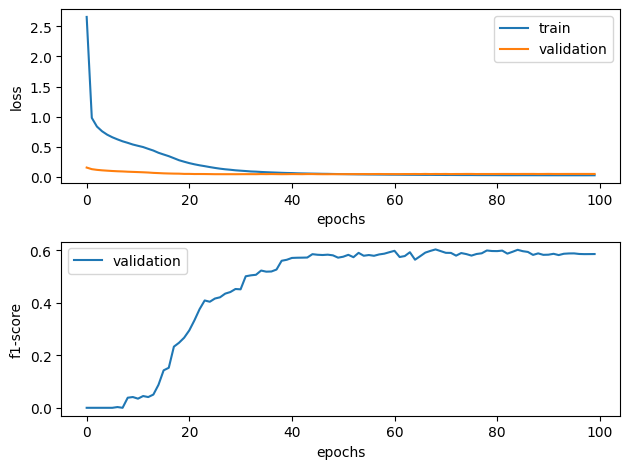

In [ ]:
def make_loss_diagram():
    plt.subplot(2, 1, 1)
    plt.plot([train_loss for _, train_loss, _, _ in history], label="train")
    plt.plot([eval_loss for _, _, eval_loss, _ in history], label="validation")
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.legend(loc="best")

    plt.subplot(2, 1, 2)
    plt.plot([eval_score for _, _, _, eval_score in history], label="validation")
    plt.xlabel("epochs")
    plt.ylabel("f1-score")
    plt.legend(loc="best")

    plt.tight_layout()
    plt.savefig(OUTPUT_DIR + "/loss.png", dpi=300)


make_loss_diagram()

INFERENCE

In [ ]:
model = model_multilabel.BertForMultiLabelClassification.from_pretrained(OUTPUT_DIR)
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)

OSError: ./serialized_models/medbert_pretrained_multilabel does not appear to have a file named config.json. Checkout 'https://huggingface.co/./serialized_models/medbert_pretrained_multilabel/main' for available files.

In [ ]:
def get_offsets_and_predicted_tags(example: str, model, tokenizer, threshold=0):
    """
    Get prediction of model on example, using tokenizer
    Args:
      - example (str): The input text
      - model: The span categorizer
      - tokenizer: The tokenizer
      - threshold: The threshold to decide whether the token should belong to the label. Default to 0, which corresponds to probability 0.5.
    Returns:
      - List of (token, tags, offset) for each token.
    """
    # Tokenize the sentence to retrieve the tokens and offset mappings
    raw_encoded_example = tokenizer(example, return_offsets_mapping=True)
    encoded_example = tokenizer(example, return_tensors="pt").to(device)
    
    # Call the model. The output LxK-tensor where L is the number of tokens, K is the number of classes
    out = model(**encoded_example)["logits"][0]
    
    # We assign to each token the classes whose logit is positive
    predicted_tags = [[i for i, l in enumerate(logit) if l > threshold] for logit in out]
    
    return [{"token": token, "tags": tag, "offset": offset} for (token, tag, offset) 
            in zip(tokenizer.batch_decode(raw_encoded_example["input_ids"]), 
                   predicted_tags, 
                   raw_encoded_example["offset_mapping"])]

In [ ]:
example = "Du coup, la menace des feux de forêt est permanente, après les incendies dévastateurs de juillet dans le sud-ouest de la France, en Espagne, au Portugal ou en Grèce. Un important feu de forêt a éclaté le 24 juillet dans le parc national de la Suisse de Bohême, à la frontière entre la République tchèque et l'Allemagne, où des records de chaleur ont été battus (36,4C). Un millier d'hectares ont déjà été touchés. Lundi, les pompiers espéraient que l'incendie pourrait être maîtrisé en quelques jours."
for item in get_offsets_and_predicted_tags(example, model, tokenizer):
    print(f"""{item["token"]:15} - {item["tags"]}""")

[CLS]           - []
Du              - []
co              - []
##up            - []
,               - []
la              - [9]
men             - [10]
##ace           - [10]
des             - [10]
fe              - [10]
##ux            - [10]
de              - [10]
for             - [10]
##ê             - []
##t             - []
es              - []
##t             - []
perman          - []
##ente          - []
,               - []
ap              - []
##r             - []
##è             - []
##s             - []
les             - [9]
inc             - [10]
##end           - [10]
##ies           - [10]
d               - [10]
##é             - [10]
##vas           - [10]
##ta            - [10]
##teu           - [10]
##r             - [10]
##s             - [10]
de              - [10]
ju              - [10]
##ille          - [10]
##t             - [10]
da              - []
##ns            - []
le              - [9]
su              - [10]
##d             - [10]
-               - [10]
o   

In [ ]:
def get_tagged_groups(example: str, model, tokenizer):
    """
    Get prediction of model on example, using tokenizer
    Returns:
    - List of spans under offset format {"start": ..., "end": ..., "tag": ...}, sorted by start, end then tag.
    """
    offsets_and_tags = get_offsets_and_predicted_tags(example, model, tokenizer)
    predicted_offsets = {l: [] for l in tag2id}
    last_token_tags = []
    for item in offsets_and_tags:
        (start, end), tags = item["offset"], item["tags"]
        
        for label_id in tags:
            label = id2label[label_id]
            tag = label[2:] # "I-PER" => "PER"
            if label.startswith("B-"):
                predicted_offsets[tag].append({"start": start, "end": end})
            elif label.startswith("I-"):
                # If "B-" and "I-" both appear in the same tag, ignore as we already processed it
                if label2id[f"B-{tag}"] in tags:
                    continue
                
                if label_id not in last_token_tags and label2id[f"B-{tag}"] not in last_token_tags:
                    predicted_offsets[tag].append({"start": start, "end": end})
                else:
                    predicted_offsets[tag][-1]["end"] = end
        
        last_token_tags = tags
        
    flatten_predicted_offsets = [{**v, "tag": k, "text": example[v["start"]:v["end"]]} 
                                 for k, v_list in predicted_offsets.items() for v in v_list if v["end"] - v["start"] >= 3]
    flatten_predicted_offsets = sorted(flatten_predicted_offsets, 
                                       key = lambda row: (row["start"], row["end"], row["tag"]))
    return flatten_predicted_offsets

print(example)
get_tagged_groups(example, model, tokenizer)

Du coup, la menace des feux de forêt est permanente, après les incendies dévastateurs de juillet dans le sud-ouest de la France, en Espagne, au Portugal ou en Grèce. Un important feu de forêt a éclaté le 24 juillet dans le parc national de la Suisse de Bohême, à la frontière entre la République tchèque et l'Allemagne, où des records de chaleur ont été battus (36,4C). Un millier d'hectares ont déjà été touchés. Lundi, les pompiers espéraient que l'incendie pourrait être maîtrisé en quelques jours.


[{'start': 9, 'end': 34, 'tag': 'NCHUNK', 'text': 'la menace des feux de for'},
 {'start': 59,
  'end': 96,
  'tag': 'NCHUNK',
  'text': 'les incendies dévastateurs de juillet'},
 {'start': 102, 'end': 117, 'tag': 'NCHUNK', 'text': 'le sud-ouest de'},
 {'start': 121, 'end': 127, 'tag': 'LOC', 'text': 'France'},
 {'start': 129, 'end': 139, 'tag': 'PLACE', 'text': 'en Espagne'},
 {'start': 132, 'end': 139, 'tag': 'LOC', 'text': 'Espagne'},
 {'start': 141, 'end': 155, 'tag': 'PLACE', 'text': 'au Portugal ou'},
 {'start': 144, 'end': 155, 'tag': 'LOC', 'text': 'Portugal ou'},
 {'start': 156, 'end': 164, 'tag': 'PLACE', 'text': 'en Grèce'},
 {'start': 159, 'end': 164, 'tag': 'LOC', 'text': 'Grèce'},
 {'start': 220,
  'end': 259,
  'tag': 'NCHUNK',
  'text': 'le parc national de la Suisse de Bohême'},
 {'start': 243, 'end': 259, 'tag': 'LOC', 'text': 'Suisse de Bohême'},
 {'start': 285, 'end': 303, 'tag': 'LOC', 'text': 'République tchèque'},
 {'start': 286, 'end': 303, 'tag': 'PLACE', 'text